In [20]:
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import datetime
import json as jsn
import geopandas as gpd
import shapely as shply
import rle as rle
import os as os

from scipy.special import expit

from werp_projecting_sfis.get_rating_tables_and_cross_sections import * 

In [21]:
parentdire = '//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/'
filelist = os.listdir('//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/')
filelist = [file for file in filelist if '.nc' in file]
filelist = [parentdire + file for file in filelist if '_P0' in file]
filelist

['//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0D000_flow.nc',
 '//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0H000_flow.nc',
 '//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0M000_flow.nc',
 '//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0W000_flow.nc']

In [22]:
scenarios = [file.split('0')[1] for file in filelist]
scenarios

['D', 'H', 'M', 'W']

In [23]:
mdbboundary = gpd.read_file("Z:/Data/GIS/General/mdb_boundary.shp")

In [24]:
filelist

['//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0D000_flow.nc',
 '//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0H000_flow.nc',
 '//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0M000_flow.nc',
 '//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0W000_flow.nc']

In [25]:
infiles = xr.open_mfdataset(filelist, combine = 'nested', concat_dim= 'scenario')



In [26]:
infiles = infiles.assign_coords({'scenario' :scenarios})

In [27]:
infile_histemp = xr.open_dataset("L:/work/fre171/Spatial/silo_sfi_drill_max_temp.nc")

In [28]:
infile_hist = xr.open_dataset("//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0H000_flow.nc")
infile_fut = xr.open_dataset("//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0D000_flow.nc") 



In [29]:
infile_hist

<xarray.Dataset> Size: 72MB
Dimensions:         (station: 214, time: 41638)
Coordinates:
  * station         (station) int32 856B 1 2 3 4 5 6 ... 209 210 211 212 213 214
  * time            (time) datetime64[ns] 333kB 1895-07-01 ... 2009-06-30
Data variables:
    station_me      (station) <U48 41kB ...
    station_no      (station) <U8 7kB ...
    station_id      (station) int32 856B ...
    Site            (station) <U7 6kB ...
    spatial_coords  (station) <U94 80kB ...
    lon             (station) float64 2kB ...
    lat             (station) float64 2kB ...
    flow            (station, time) float64 71MB ...
Attributes:
    title:           A continuous daily time series of data generated from IR...
    institution:     MDBA
    source:          IRSMF Outlook23 model results
    catchment:       Murray-Darling Basin
    history:         This data has been generated by the IRSMF for the Outloo...
    comment:         CSIRO has migrated these datasets to netcdf for the purp...
    MDBA_attrs:      Capture required attributes for MDBA data registry systems
    crs:             4283
    data variables:  Flow

In [30]:
infile_hist['station_no'].values

array(['407252', '422028', '422026', '422002', '422001', '422027',
       '422004', '422025', '422003', '416001', '416050', '416008',
       '412009', '410134', '410016', '422013', '421069', '421023',
       '421039', '421076', '422005', '416028', '416037', '404216',
       '409075', '422207A', '422201F', '422203A', '422209A', '422211A',
       '421079', '406202', '406265', '406207', '406218', '421101',
       '418052', '418011', '420020', '419016', '406200', '409024',
       '410014', '419032', '420004', '421019', '422015', '423005',
       '423201A', 'A4261091', '422325A', '425011', '425003', '425007',
       '425004', '425900', '425039', '425008', '416007', '416049',
       '416011', '416310A', '409014', '409047', '409023', '416052',
       '416027', '405232', '405203', '405201', '409030', '407209',
       '418007', '418008', '418013', '418006', '418066', '418012',
       '418029', '418004', '418026', '402205', '425014', '412005',
       '412021', '412067', '412004', '412039', '4120

In [31]:
[x for x in infile_hist['station_no'].values if '405' in x]

['405232', '405203', '405201']

In [32]:
sites_to_use1 = np.where(np.isfinite(infile_hist['flow']).all(dim = "time"))

In [33]:
sites_to_use1

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  25,  26,  27,  28,
         29,  30,  35,  36,  37,  38,  39,  42,  43,  44,  45,  46,  47,
         48,  50,  52,  54,  55,  56,  57,  58,  59,  60,  61,  65,  66,
         72,  73,  74,  75,  76,  77,  78,  79,  80,  83,  84,  85,  86,
         87,  88,  89,  90,  91,  92,  93,  94, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 136, 137, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170,
        171, 172, 173, 176, 185, 186, 187, 190, 194, 195, 196, 197, 199,
        200, 201, 202, 204, 205, 207, 209, 210, 211, 212, 213], dtype=int64),)

In [34]:
sites_to_use = np.where(np.isfinite(infile_hist['flow']).any(dim = "time"))

In [35]:
sites_to_use[0].shape

(154,)

In [36]:
sites_to_use = np.where(np.isfinite(infile_hist['flow']).all(dim = "time"))

In [37]:
infile_hist['station_no'][sites_to_use].values

array(['422028', '422026', '422002', '422001', '422027', '422004',
       '422025', '422003', '416001', '416050', '416008', '412009',
       '410134', '410016', '422013', '421069', '421023', '421039',
       '421076', '422005', '416028', '416037', '422207A', '422201F',
       '422203A', '422209A', '422211A', '421079', '421101', '418052',
       '418011', '420020', '419016', '410014', '419032', '420004',
       '421019', '422015', '423005', '423201A', '422325A', '425003',
       '425004', '425900', '425039', '425008', '416007', '416049',
       '416011', '416310A', '416052', '416027', '418007', '418008',
       '418013', '418006', '418066', '418012', '418029', '418004',
       '418026', '412005', '412021', '412067', '412004', '412039',
       '412036', '412048', '412011', '412002', '412057', '412026',
       '412038', '422395A', '410033', '410008', '410130', '410040',
       '410021', '410005', '410001', '416038', '416018', '416012',
       '416048', '416047', '416010', '421004', '42109

In [38]:
stationid = infile_hist['station_no'][sites_to_use].values[20]
stationid

'416028'

<Axes: >

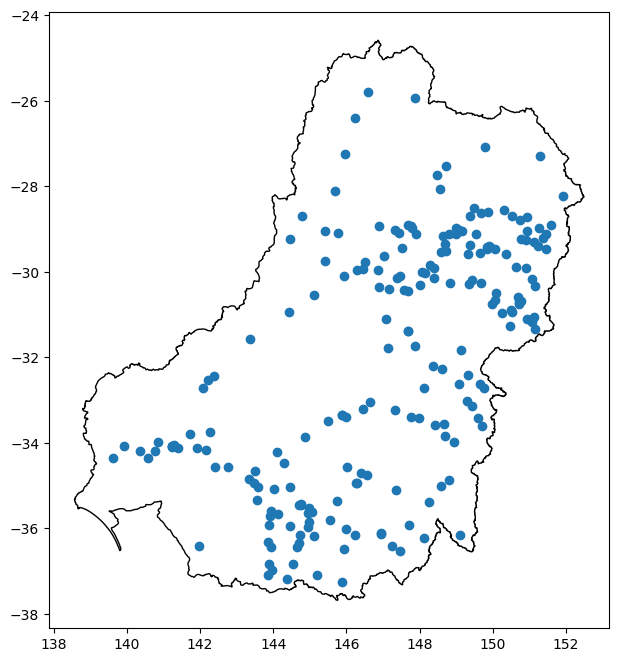

In [39]:

fig, axs = plt.subplots(1,1,figsize=(8,8) )
df = pd.DataFrame({'lat': infile_hist['lat'] ,'lon': infile_hist['lon'],'id': infile_hist['station_no']})

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326" )

gdf.plot(ax = axs)
mdbboundary.plot(color='None', ax = axs)

<Axes: >

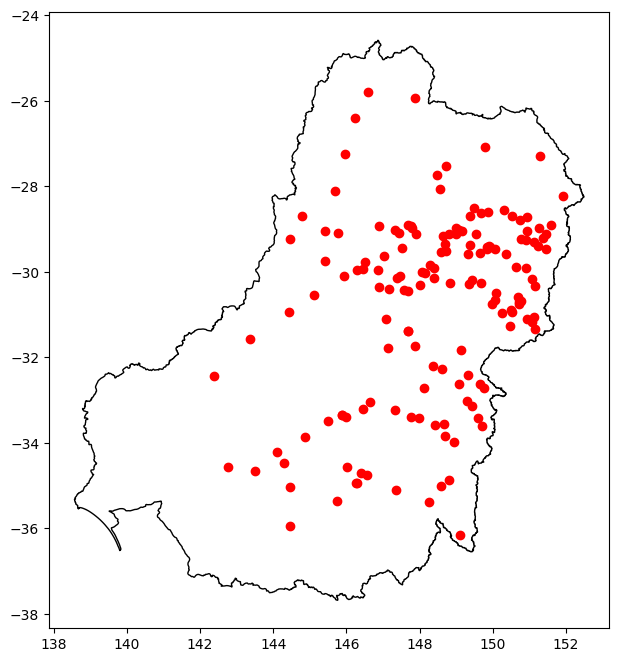

In [40]:
fig, axs = plt.subplots(1,1,figsize=(8,8) )
df = pd.DataFrame({'lat': infile_hist['lat'][sites_to_use] ,'lon': infile_hist['lon'][sites_to_use],'id': infile_hist['station_no'][sites_to_use]})

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326" )

gdf.plot(ax = axs, c="red")
mdbboundary.plot(color='None', ax = axs)

In [41]:
i = sites_to_use[0][4]
print(i)

starttime = max(infile_hist['time'].min(), infile_histemp['time'].min()).values
endtime = min(infile_hist['time'].max(), infile_histemp['time'].max()).values
print(starttime, endtime)


indata = infile_hist['flow'][i].sel(time = slice(starttime, endtime))
infut = infile_fut['flow'][i].sel(time = slice(starttime, endtime))
intemp = infile_histemp['max_temp'][i].sel(time = slice(starttime, endtime))

probs = [0.1,0.05,0.02,0.01,0.005]
quants = indata.quantile(q =probs)
print(quants.values)

tempthresholds = [-100,35,40,45]
nyears = round((endtime-starttime)/pd.Timedelta('365.25 days'))
nyears

5
1895-07-01T00:00:00.000000000 2009-06-30T00:00:00.000000000
[152.76472778 107.53434181  70.60105057  54.99146206  43.37036148]


114

c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


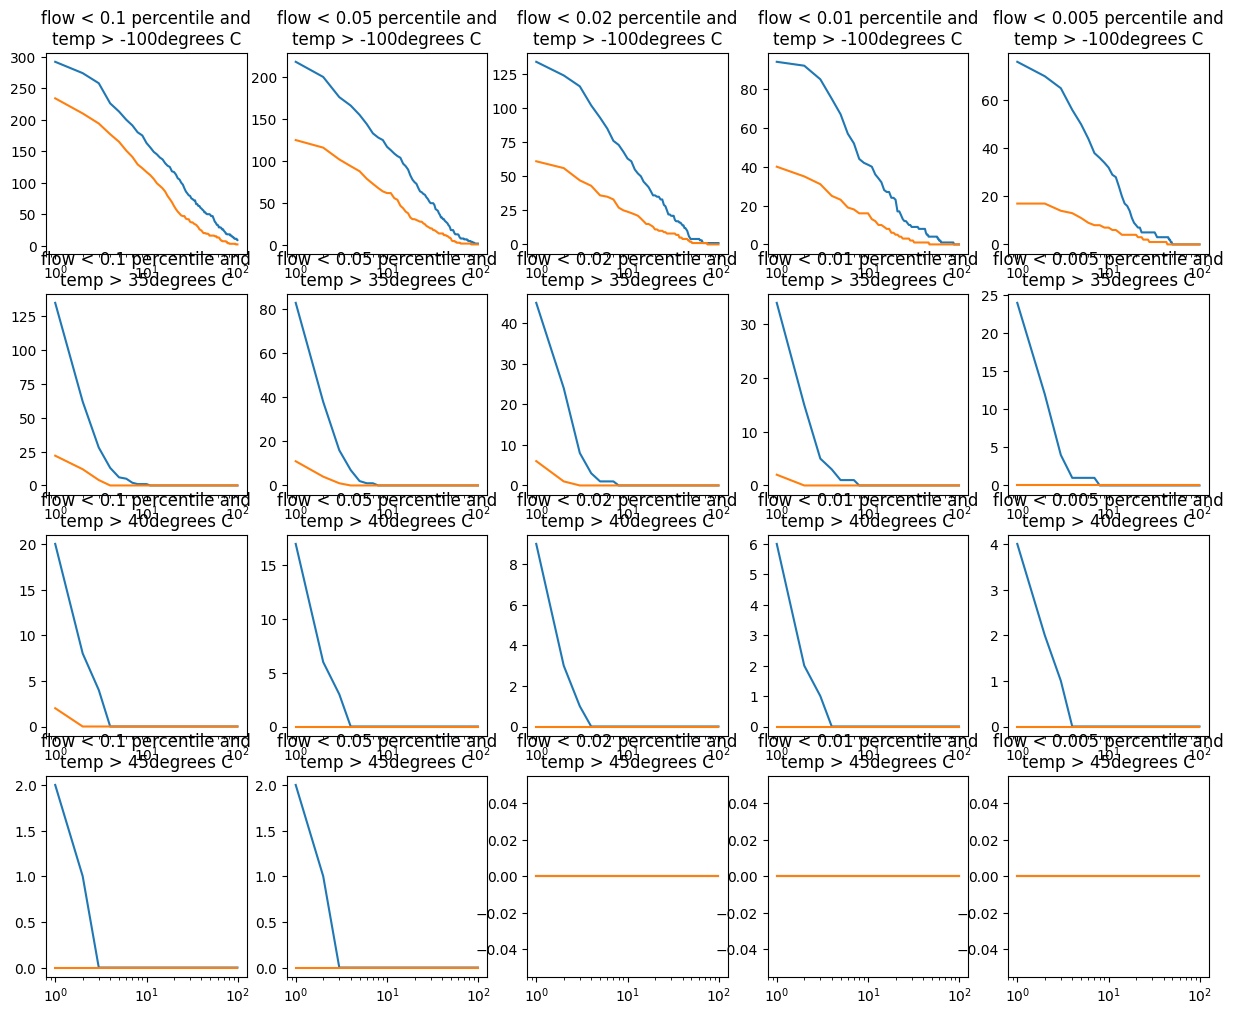

In [42]:
thresholdi = 0
thresholdj = 2
nx = len(quants.values)
ny =  len(tempthresholds)
figsize = 3

fig, ax = plt.subplots(ny,nx, figsize=(nx*figsize,ny*figsize))

outsummary = pd.DataFrame()

for thresholdi in range(len(quants.values)):
    for thresholdj in range(len(tempthresholds)):
        testdata = indata.values<quants.values[thresholdi]
        test2data = intemp.values > tempthresholds[thresholdj]
        encoding = rle.encode(testdata & test2data)
        trues = np.array([ encoding[1][a] for a in range(len(encoding[0])) if encoding[0][a]])

        testdatafut = infut.values<quants.values[thresholdi]
        test2datafut = intemp.values > (tempthresholds[thresholdj]-3.4)
        encodingfut = rle.encode(testdatafut & test2datafut)
        truesfut = np.array([ encodingfut[1][a] for a in range(len(encodingfut[0])) if encodingfut[0][a]])

        histbins = [a for a in range(1,100,1)]

        futtrues = [sum(truesfut>a) for a in histbins]
        histtrues = [sum(trues>a) for a in histbins]

        ax[thresholdj,thresholdi].plot(histbins, futtrues)
        ax[thresholdj,thresholdi].plot(histbins, histtrues)
        ax[thresholdj,thresholdi].set_xscale('log')
        ax[thresholdj,thresholdi].set_title( 'flow < ' + str(probs[thresholdi]) + ' percentile and\ntemp > ' + str(tempthresholds[thresholdj]) + 'degrees C' )

        pdout = pd.DataFrame({'temp_treshold': [ tempthresholds[thresholdj]], 'flow_percentile': [probs[thresholdi]], 'flow_treshold' : [quants.values[thresholdi]],
                             'mean_event_length_hist': [np.mean(trues)],'mean_event_length_future': [ np.mean(truesfut)], 
                             'event_frequency_hist': [(trues.shape[0]/nyears)], 'event_frequency_future':[truesfut.shape[0]/nyears]})
        #print(pdout)
        outsummary = pd.concat([outsummary, pdout])
#print(sum(trues), sum(truesfut))


In [43]:
outsummary

,temp_treshold,flow_percentile,flow_treshold,mean_event_length_hist,mean_event_length_future,event_frequency_hist,event_frequency_future
0,-100,0.100,152.764728,16.656000,24.374194,2.192982,2.719298
0,35,0.100,152.764728,1.513514,1.927007,0.649123,2.403509
0,40,0.100,152.764728,1.200000,1.355556,0.087719,0.789474
0,45,0.100,152.764728,1.000000,1.428571,0.017544,0.061404
0,-100,0.050,107.534342,15.422222,18.648536,1.184211,2.096491
0,35,0.050,107.534342,1.444444,1.826816,0.315789,1.570175
0,40,0.050,107.534342,1.000000,1.472727,0.043860,0.482456
0,45,0.050,107.534342,1.000000,1.428571,0.017544,0.061404
0,-100,0.020,70.601051,12.815385,15.719424,0.570175,1.219298
0,35,0.020,70.601051,1.466667,1.902174,0.131579,0.807018


In [44]:
np.where(np.isfinite(infiles['flow'].isel({'scenario':0})).all(dim = "time"))

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  25,  26,  27,  28,
         29,  30,  35,  36,  37,  38,  39,  42,  43,  44,  45,  46,  47,
         48,  50,  52,  54,  55,  56,  57,  58,  59,  60,  61,  65,  66,
         72,  73,  74,  75,  76,  77,  78,  79,  80,  83,  84,  85,  86,
         87,  88,  89,  90,  91,  92,  93,  94, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 136, 137, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170,
        171, 172, 173, 176, 185, 186, 187, 190, 194, 195, 196, 197, 199,
        200, 201, 202, 204, 205, 207, 209, 210, 211, 212, 213], dtype=int64),)

In [45]:

sites_to_use = np.where(np.isfinite(infiles['flow'].isel({'scenario':0})).all(dim = "time"))
i = sites_to_use[0][4]
print(i)

starttime = max(infiles['time'].min(), infile_histemp['time'].min()).values
endtime = min(infiles['time'].max(), infile_histemp['time'].max()).values
print(starttime, endtime)


indata = infiles['flow'].isel({'station':i}).sel(time = slice(starttime, endtime))
#infut = infile_fut['flow'][i].sel(time = slice(starttime, endtime))
intemp = infile_histemp['max_temp'][i].sel(time = slice(starttime, endtime))

probs = [0.99,0.90,0.05,0.01]
indata = indata.chunk(dict(scenario=-1, time = -1))
quants = indata.quantile(q =probs, dim=['time']).sel({'scenario':"H"}).values
print(quants)

tempthresholds = [-100,35,40,45]
nyears = round((endtime-starttime)/pd.Timedelta('365.25 days'))
print(nyears)

scenariotemps = np.array([3.0,0.0,2.9,2.1])


5
1895-07-01T00:00:00.000000000 2009-06-30T00:00:00.000000000
[7.49523034e+04 1.07630308e+04 1.07534342e+02 5.49914621e+01]
114


In [46]:
def encodingfunc(data, bins):
    encoding = rle.encode(data)
    trues = np.array([ encoding[1][a] for a in range(len(encoding[0])) if encoding[0][a]])
    futtrues = np.array([sum(trues>a) for a in bins])
    return(futtrues)

def xrencoding(obj, dim, bins):
    return xr.apply_ufunc(encodingfunc, obj, input_core_dims = [[dim]], output_core_dims=[['counts']], vectorize=True, dask = 'parallelized', output_dtypes=[np.int_], kwargs={'bins':bins})

def encodingfunc1(data, bins):
    encoding = rle.encode(data)
    trues = np.array([ encoding[1][a] for a in range(len(encoding[0])) if encoding[0][a]])
    futtrues = np.array([sum(trues>a) for a in bins])
    return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])

def xrencoding1(obj, dim, bins):
    return xr.apply_ufunc(encodingfunc1, obj, input_core_dims = [[dim]], output_core_dims=[['counts'], ['means'],['lengths']], vectorize=True, dask = 'parallelized', output_dtypes=[np.int_,np.float_, np.int_], kwargs={'bins':bins})


In [47]:
thresholdi = 0
thresholdj = 2
nx = len(quants)
ny =  len(tempthresholds)
figsize = 3
nbins = 10000
#fig, ax = plt.subplots(ny,nx, figsize=(nx*figsize,ny*figsize))
bins = np.array([a for a in range(1,nbins,1)])
outsummary = pd.DataFrame()

testdata = indata<quants[thresholdi]
test2data = intemp > tempthresholds[thresholdj]
combined = (testdata & test2data)
combined = combined.compute()
result = xrencoding(combined,'time', bins=bins)
result = result.assign_coords({'counts':bins})

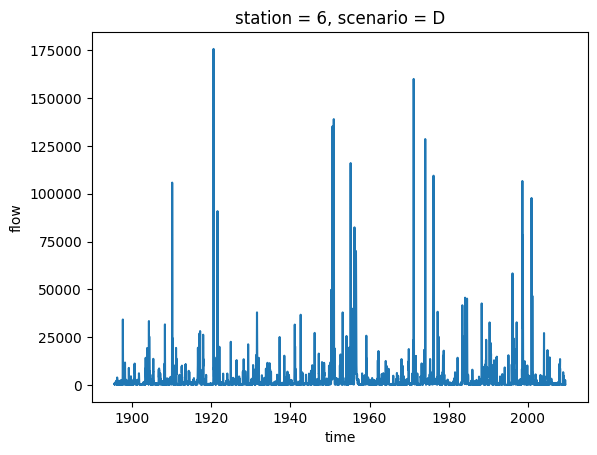

In [48]:
indata.loc[{'scenario':'D'}].plot()

In [49]:
encoding = rle.encode((indata.loc[{'scenario':'D'}]<=quants[0]).values)

In [50]:
trues = np.array([ encoding[1][a] for a in range(len(encoding[0])) if encoding[0][a]])
futtrues = np.array([sum(trues>a) for a in bins])

In [51]:
futtrues

array([14, 14, 14, ...,  1,  1,  1])

In [54]:
colors = {'H':'tab:green', 'W':'tab:blue', 'D':'tab:red', 'M':'tab:orange'}

C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: Runtime

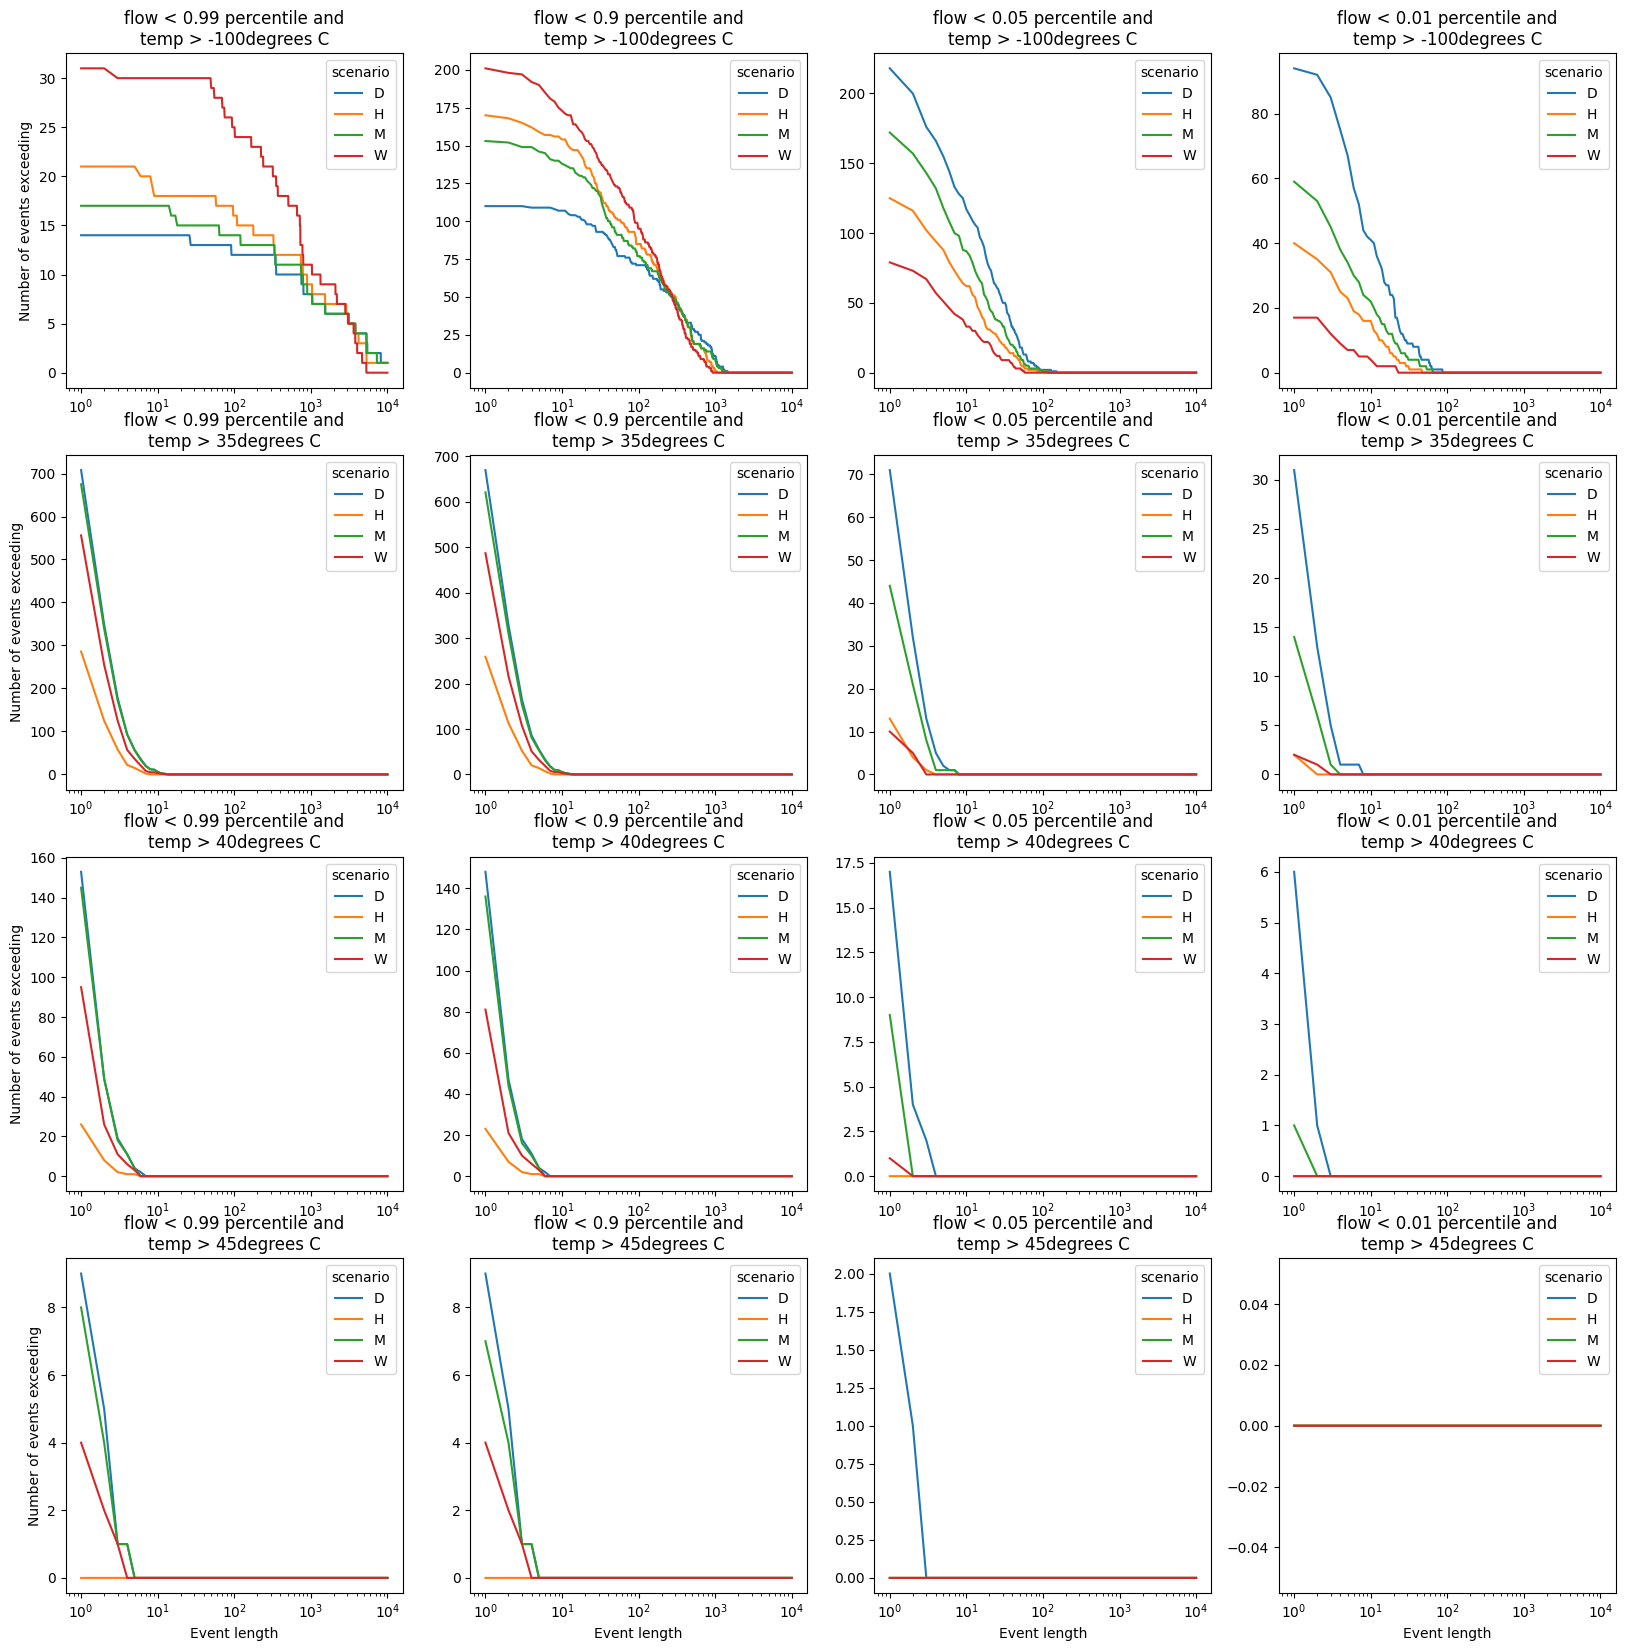

In [52]:
nx = len(quants)
ny =  len(tempthresholds)
figsize = 5
nbins = 10000
bins = np.array([a for a in range(1,nbins,1)])
fig, ax = plt.subplots(ny,nx, figsize=(nx*figsize,ny*figsize))

for thresholdi in range(len(quants)):
    for thresholdj in range(len(tempthresholds)):
        testdata = indata<=quants[thresholdi]
        test2data = testdata.copy(deep=True)
        for scen in range(len(scenariotemps)):
            test2data[scen,:] = intemp >= (tempthresholds[thresholdj]- scenariotemps[scen])
        combined = (testdata & test2data)
        combined = combined.compute()
        result, means, counts = xrencoding1(combined,'time', bins=bins)
        result = result.assign_coords({'counts':bins})
        result.plot.line(hue = 'scenario', ax =  ax[thresholdj,thresholdi])

        ax[thresholdj,thresholdi].set_xscale('log')
        if(thresholdj==(len(tempthresholds)-1)):
            ax[thresholdj, thresholdi].set_xlabel('Event length')
        else:
            ax[thresholdj, thresholdi].set_xlabel('')
        if(thresholdi==0):    
            ax[thresholdj, thresholdi].set_ylabel('Number of events exceeding')
        else:
            ax[thresholdj, thresholdi].set_ylabel('')
        ax[thresholdj,thresholdi].set_title( 'flow < ' + str(probs[thresholdi]) + ' percentile and\ntemp > ' + str(tempthresholds[thresholdj]) + 'degrees C' )
        pdout = pd.DataFrame({ 'scenarios':scenarios, 'mean_event_length': means.values[:,0], 'event_frequency': counts.values[:,0]/nyears, '5day_event_frequency': result.sel({'counts':5}).values/nyears})
        pdout['temp_treshold'] =  tempthresholds[thresholdj]
        pdout['flow_percentile'] =  probs[thresholdi]
        pdout['flow_treshold'] =  quants[thresholdi]
        # print(pdout)
        outsummary = pd.concat([outsummary, pdout])
#print(sum(trues), sum(truesfut))


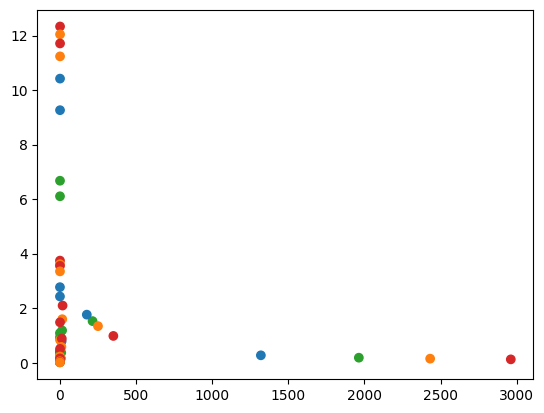

In [53]:
colors = {'H':'tab:green', 'W':'tab:blue', 'D':'tab:red', 'M':'tab:orange'}
plt.scatter(x = outsummary['mean_event_length'], y = outsummary['event_frequency'], c=outsummary['scenarios'].map(colors))

In [55]:
outsummary['5day_event_frequency']

0    0.122807
1    0.184211
2    0.149123
3    0.263158
0    0.500000
       ...   
3    0.000000
0    0.000000
1    0.000000
2    0.000000
3    0.000000
Name: 5day_event_frequency, Length: 64, dtype: float64

In [57]:
sites_to_use = np.where(np.isfinite(infiles['flow'].isel({'scenario':0})).all(dim = "time"))[0]
len(sites_to_use)

154

In [ ]:
sites_to_use = np.where(np.isfinite(infiles['flow'].isel({'scenario':0})).all(dim = "time"))[0]

outsummary = pd.DataFrame()
starttime = max(infiles['time'].min(), infile_histemp['time'].min()).values
endtime = min(infiles['time'].max(), infile_histemp['time'].max()).values
print(starttime, endtime)
probs = [0.99,.5, 0.1,0.05, 0.01,0.005, 0.002] #,0.02,0.01,0.005]
tempthresholds = [-100,35,40,45]
nyears = round((endtime-starttime)/pd.Timedelta('365.25 days'))
print(nyears)

scenariotemps = np.array([3.0,0.0,2.9,2.1])

for j in range(len(sites_to_use)):

    i = sites_to_use[j]
    print(i)

    indata = infiles['flow'].isel({'station':i}).sel(time = slice(starttime, endtime))
    #infut = infile_fut['flow'][i].sel(time = slice(starttime, endtime))
    intemp = infile_histemp['max_temp'][i].sel(time = slice(starttime, endtime))
    indata = indata.chunk(dict(scenario=-1, time = -1))
    quants = indata.quantile(q =probs, dim=['time']).sel({'scenario':"H"}).values
    #quants = np.array([1,5,10])/86.4
    for thresholdi in range(len(quants)):
        for thresholdj in range(len(tempthresholds)):
            testdata = indata<=quants[thresholdi]
            test2data = testdata.copy(deep=True)
            for scen in range(len(scenariotemps)):
                test2data[scen,:] = intemp >= (tempthresholds[thresholdj]- scenariotemps[scen])
            combined = (testdata & test2data)
            combined = combined.compute()
            result, means, counts = xrencoding1(combined,'time', bins=bins)
            result = result.assign_coords({'counts':bins})
            pdout = pd.DataFrame({ 'scenarios':scenarios, 'mean_event_length': means.values[:,0], 'event_frequency': counts.values[:,0]/nyears, '5day_event_frequency': result.sel({'counts':5}).values/nyears})
            pdout['temp_treshold'] =  tempthresholds[thresholdj]
            pdout['flow_percentile'] =  probs[thresholdi]
            pdout['flow_treshold'] =  quants[thresholdi]
            pdout['site'] =  infiles['station_no'].isel({'station':i}).values
            pdout['lat'] = infiles['lat'].isel({'station':i}).values
            pdout['lon'] = infiles['lon'].isel({'station':i}).values
            # print(pdout)
            outsummary = pd.concat([outsummary, pdout])
    #print(sum(trues), sum(truesfut))


1895-07-01T00:00:00.000000000 2009-06-30T00:00:00.000000000
114
1


C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: Runtime

2


C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: Runtime

3


C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: Runtime

4


C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: Runtime

5


C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: Runtime

6


C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: Runtime

7


C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: Runtime

8


C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: Runtime

9


C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: Runtime

10


C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: Runtime

11
12


C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: Runtime

13


C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: Runtime

14


C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rob635\AppData\Local\Temp\ipykernel_26584\188703509.py:14: RuntimeWarning: Mean of empty slice.
  return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])
c:\src\github_dr\WERP_projecting_SFIs\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


15
16


In [ ]:
outsummary

In [ ]:
outsummary['flow_percentile'].unique()

In [43]:
outplot = outsummary[outsummary['flow_percentile']==0.1]
outplot = outplot[outplot['temp_treshold']==35]
outplot['scen_cat'] = outplot["scenarios"].astype('category')
outplot["scen_cat"] = outplot["scen_cat"].cat.reorder_categories(["H", "D", "M", "W"] )

In [ ]:
plot_variable_name = 'event_frequency'

maxscale = outplot[plot_variable_name].max()
nbounds = int(np.ceil( maxscale))
bounds = np.power(2, np.arange(np.log2(1), np.ceil(np.log2(nbounds))+1))

ncolors = len(bounds) - 1


cmap = plt.get_cmap('jet', ncolors)
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)

fig, axs = plt.subplots(2,3,figsize=(15,10) )

fig.delaxes(axs[0,0])
fig.delaxes(axs[0,2])


mdbboundary.plot(color = 'None', ax = axs[0,1])
spdata = outplot[outplot['scenarios']=="H"]
sc = axs[0,1].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
axs[0,1].set_title("Historical")

mdbboundary.plot(color = 'None', ax = axs[1,0])
spdata = outplot[outplot['scenarios']=="W"]
sc = axs[1,0].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
axs[1,0].set_title("Future Wet")

mdbboundary.plot(color = 'None', ax = axs[1,1])
spdata = outplot[outplot['scenarios']=="M"]
sc = axs[1,1].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
axs[1,1].set_title("Future Mid")

mdbboundary.plot(color = 'None', ax = axs[1,2])
spdata = outplot[outplot['scenarios']=="D"]
sc = axs[1,2].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
axs[1,2].set_title("Future Dry")


fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label = "Event frequency (per year)")



In [ ]:
plot_variable_name = '5day_event_frequency'

maxscale = outplot[plot_variable_name].max()
nbounds = int(np.ceil( maxscale))
bounds = np.power(2, np.arange(np.log2(1), np.ceil(np.log2(nbounds))+1))

ncolors = len(bounds) - 1


cmap = plt.get_cmap('jet', ncolors)
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)

fig, axs = plt.subplots(2,3,figsize=(15,10) )

fig.delaxes(axs[0,0])
fig.delaxes(axs[0,2])


mdbboundary.plot(color = 'None', ax = axs[0,1])
spdata = outplot[outplot['scenarios']=="H"]
sc = axs[0,1].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
axs[0,1].set_title("Historical")

mdbboundary.plot(color = 'None', ax = axs[1,0])
spdata = outplot[outplot['scenarios']=="W"]
sc = axs[1,0].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
axs[1,0].set_title("Future Wet")

mdbboundary.plot(color = 'None', ax = axs[1,1])
spdata = outplot[outplot['scenarios']=="M"]
sc = axs[1,1].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
axs[1,1].set_title("Future Mid")

mdbboundary.plot(color = 'None', ax = axs[1,2])
spdata = outplot[outplot['scenarios']=="D"]
sc = axs[1,2].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
axs[1,2].set_title("Future Dry")


fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label = "5-day event frequency (per year)")



In [ ]:
maxscale

In [ ]:
plot_variable_name = 'mean_event_length'

maxscale = outplot[plot_variable_name].max()
nbounds = int(np.ceil( maxscale))
bounds = np.power(2, np.arange(np.log2(1), np.ceil(np.log2(nbounds))+1))

ncolors = len(bounds) - 1


cmap = plt.get_cmap('jet', ncolors)
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)

fig, axs = plt.subplots(2,3,figsize=(15,10) )

fig.delaxes(axs[0,0])
fig.delaxes(axs[0,2])


mdbboundary.plot(color = 'None', ax = axs[0,1])
spdata = outplot[outplot['scenarios']=="H"]
sc = axs[0,1].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
axs[0,1].set_title("Historical")

mdbboundary.plot(color = 'None', ax = axs[1,0])
spdata = outplot[outplot['scenarios']=="W"]
sc = axs[1,0].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
axs[1,0].set_title("Future Wet")

mdbboundary.plot(color = 'None', ax = axs[1,1])
spdata = outplot[outplot['scenarios']=="M"]
sc = axs[1,1].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
axs[1,1].set_title("Future Mid")

mdbboundary.plot(color = 'None', ax = axs[1,2])
spdata = outplot[outplot['scenarios']=="D"]
sc = axs[1,2].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata[plot_variable_name], norm = norm,cmap = cmap)
axs[1,2].set_title("Future Dry")


fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label = "Average event length (days)")



In [ ]:
sites_to_use = np.where(np.isfinite(infiles['flow'].isel({'scenario':0})).all(dim = "time"))[0]

outsummary = pd.DataFrame()
starttime = max(infiles['time'].min(), infile_histemp['time'].min()).values
endtime = min(infiles['time'].max(), infile_histemp['time'].max()).values
print(starttime, endtime)
probs = [0.99,0.95,0.90] #,0.02,0.01,0.005]

nyears = round((endtime-starttime)/pd.Timedelta('365.25 days'))
print(nyears)

scenariotemps = np.array([3.0,0.0,2.9,2.1])

for j in range(len(sites_to_use)):

    i = sites_to_use[j]
    print(i)

    indata = infiles['flow'].isel({'station':i}).sel(time = slice(starttime, endtime))
    #infut = infile_fut['flow'][i].sel(time = slice(starttime, endtime))
    intemp = infile_histemp['max_temp'][i].sel(time = slice(starttime, endtime))
    indata = indata.chunk(dict(scenario=-1, time = -1))
    quants = indata.quantile(q =probs, dim=['time']).sel({'scenario':"H"}).values
    #quants = np.array([1,5,10])/86.4
    for thresholdi in range(len(quants)):
        #for thresholdj in range(len(tempthresholds)):
            testdata = indata<=quants[thresholdi]
            # test2data = testdata.copy(deep=True)
            # for scen in range(len(scenariotemps)):
            #     test2data[scen,:] = intemp >= (tempthresholds[thresholdj]- scenariotemps[scen])
            combined = (testdata) # & test2data)
            combined = combined.compute()
            result, means, counts = xrencoding1(combined,'time', bins=bins)
            result = result.assign_coords({'counts':bins})
            pdout = pd.DataFrame({ 'scenarios':scenarios, 'mean_event_length': means.values[:,0], 'event_frequency': counts.values[:,0]/nyears, '5day_event_frequency': result.sel({'counts':365}).values/nyears})
            pdout['temp_treshold'] =  tempthresholds[thresholdj]
            pdout['flow_percentile'] =  probs[thresholdi]
            pdout['flow_treshold'] =  quants[thresholdi]
            pdout['site'] =  infiles['AWRC_gauge'].isel({'station':i}).values
            pdout['lat'] = infiles['lat'].isel({'station':i}).values
            pdout['lon'] = infiles['lon'].isel({'station':i}).values
            # print(pdout)
            outsummary = pd.concat([outsummary, pdout])
    #print(sum(trues), sum(truesfut))


In [130]:
outplot = outsummary.loc[outsummary['flow_percentile']==0.99,:].copy(deep=True)
outplot['scen_cat'] = outplot["scenarios"].astype('category')
outplot["scen_cat"] = outplot["scen_cat"].cat.reorder_categories(["H", "D", "M", "W"] )
outplot["mean_event_length"] = outplot["mean_event_length"]/365

In [ ]:
nbounds

In [ ]:
bounds = np.power(2, np.arange(np.log2(1), np.ceil(np.log2(nbounds))+1))
bounds

In [ ]:
maxscale = outplot['mean_event_length'].max()

# define the bins and normalize
nbounds = int(np.ceil( maxscale))
bounds = np.power(2, np.arange(np.log2(1), np.ceil(np.log2(nbounds))+1)) #np.logspace(np.log10(1), np.log10(nbounds),num=cmap.N)

ncolors = len(bounds) - 1


cmap = plt.get_cmap('jet', ncolors)
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)

fig, axs = plt.subplots(2,3,figsize=(15,10) )

fig.delaxes(axs[0,0])
fig.delaxes(axs[0,2])

spdata = outplot[outplot['scenarios']=="H"]
sc = axs[0,1].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata['mean_event_length'], norm = norm,cmap = cmap)

mdbboundary.plot(color = 'None', ax = axs[0,1])

axs[0,1].set_title("Historical")

mdbboundary.plot(color = 'None', ax = axs[1,0])
spdata = outplot[outplot['scenarios']=="W"]
sc = axs[1,0].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata['mean_event_length'], norm = norm,cmap = cmap)
axs[1,0].set_title("Future Wet")

mdbboundary.plot(color = 'None', ax = axs[1,1])
spdata = outplot[outplot['scenarios']=="M"]
sc = axs[1,1].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata['mean_event_length'], norm = norm,cmap = cmap)
axs[1,1].set_title("Future Mid")

mdbboundary.plot(color = 'None', ax = axs[1,2])
spdata = outplot[outplot['scenarios']=="D"]
sc = axs[1,2].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata['mean_event_length'], norm = norm,cmap = cmap)
axs[1,2].set_title("Future Dry")

fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label = "Average years between events")




In [178]:
outplot2 = outplot.copy(deep=True)
unique_scenarios = outplot['scenarios'].unique()
for s in unique_scenarios:
    outplot2.loc[outplot2['scenarios']==s,'mean_event_length'] = outplot.loc[outplot['scenarios']==s,'mean_event_length'].values - outplot.loc[outplot['scenarios']=='H','mean_event_length'].values

In [ ]:
bounds

In [ ]:
maxscale = outplot2['mean_event_length'].max()
minscale = outplot2['mean_event_length'].min()

print(minscale, maxscale)
cmap = plt.cm.coolwarm  # define the colormap


# define the bins and normalize
nbounds = int(np.ceil( maxscale))
bounds = np.power(2, np.arange(np.log2(1), np.ceil(np.log2(nbounds))+1)) #np.logspace(np.log10(1), np.log10(nbounds),num=cmap.N)
bounds = np.concatenate((-1.0*bounds, bounds))
bounds = np.sort(bounds)
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ncolors = len(bounds) - 1
cmaplist = [cmap(i) for i in range(ncolors)]

cmap = plt.get_cmap('coolwarm', ncolors)
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)
#norm = plt.Normalize(0, maxscale)
fig, axs = plt.subplots(1,3,figsize=(15,5) )

mdbboundary.plot(color = 'None', ax = axs[0])
# (outplot2[outplot2['scenarios']=="W"]).plot.scatter(x = 'lon', y = 'lat', c ='mean_event_length', norm = norm, cmap = cmap,ax = axs[0], legend = False)
spdata = outplot2[outplot2['scenarios']=="W"]
sc = axs[0].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata['mean_event_length'], norm = norm,cmap = cmap)
axs[0].set_title("Future Wet")

mdbboundary.plot(color = 'None', ax = axs[1])
# (outplot2[outplot2['scenarios']=="M"]).plot.scatter(x = 'lon', y = 'lat', c ='mean_event_length', norm = norm, cmap = cmap,ax = axs[1], legend = False)
spdata = outplot2[outplot2['scenarios']=="M"]
sc = axs[1].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata['mean_event_length'], norm = norm,cmap = cmap)
axs[1].set_title("Future Mid")

mdbboundary.plot(color = 'None', ax = axs[2])
spdata = outplot2[outplot2['scenarios']=="D"]
sc = axs[2].scatter(x = spdata['lon'], y = spdata['lat'], c =spdata['mean_event_length'], norm = norm,cmap = cmap)
axs[2].set_title("Future Dry")



fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label = "Increase in mean event length")

 

In [ ]:
labels

In [ ]:
# Sample data
data = pd.DataFrame({
    'A': np.random.rand(10),
    'B': np.random.rand(10),
    'C': np.random.rand(10)
})

# Create a colormap
cmap = plt.get_cmap('viridis')

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Normalize the color values
norm = plt.Normalize(vmin=data.values.min(), vmax=data.values.max())

# Plot each subplot with the same colormap
for i, col in enumerate(data.columns):
    sc = axes[i].scatter(data.index, data[col], c=data[col], cmap=cmap, norm=norm)
    axes[i].set_title(f'Series {col}')

# Create a single colorbar for the whole figure
fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)

plt.tight_layout()
plt.show()

In [ ]:
(outplot[outplot['scenarios']=="W"]) #-outplot.loc[outplot['scenarios']=="H"])